### 라이브러리 임포트

In [14]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

### 데이터세트 로드

In [15]:
#df=pd.read_csv("../Integrated_data/all_dataset2.csv",encoding="utf-8")
df=pd.read_excel('./modeling/optimal_data3_1/'+'Continous_2weeks_7day_1term.xlsx')
#df=pd.read_csv('../data/4개로 군집화.csv',encoding='cp949')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]

In [27]:
X

,1,3,4,5,6,7
0,45.15,72.0,0.0,0.0,0.0,148.0
1,45.15,72.0,0.0,0.0,0.0,148.0
2,45.15,72.0,0.0,0.0,0.0,148.0
3,45.15,72.0,0.0,0.0,0.0,148.0
4,45.15,72.0,0.0,0.0,0.0,148.0
...,...,...,...,...,...,...
57195,68.00,0.0,0.0,0.0,0.0,153.0
57196,68.00,0.0,0.0,0.0,0.0,153.0
57197,68.00,0.0,0.0,0.0,0.0,153.0
57198,68.00,0.0,0.0,0.0,0.0,153.0


In [16]:
#아이디 갯수 325개, 리코드 176개
df.head()

,0,1,2,3,4,5,6,7,8
0,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0
1,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0
2,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0
3,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0
4,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0


### 데이터 스케일링

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (57200, 6) (57200,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (150168, 6) (150168,)
SMOTE 적용 전 레이블 값 분포: 
 0    50056
1     4698
2     2446
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    50056
1    50056
2    50056
Name: 8, dtype: int64


### train, test dataset 나누기

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train_over, y_train_over, test_size=0.20)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.to_numpy())
y_test = torch.LongTensor(y_test.to_numpy())

train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

### 파라미터 값 정의

In [19]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
#total_dev_size = len(dev_dataset)

classes = 3
input_dim = 6

num_clients = 325
rounds = 3
batch_size = 128
epochs_per_client = 1
learning_rate = 2e-2

### GPU 설정

In [21]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

### 딥러닝 모델 클래스 정의

In [22]:
class DNNModel(torch.nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()
        self.track_layers = {'hidden_layer1': self.hidden_layer1, 'hidden_layer2': self.hidden_layer2, 'output_layer': self.output_layer}

    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 
    
    def get_track_layers(self):
        return self.track_layers
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data, 
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        print("batch",batch)
        outputs = self(images)
        print("outputs",outputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

### 클라이언트 클래스

In [23]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(DNNModel(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

### 클라이언트 셋업

In [24]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

### 중앙 서버 시작

In [25]:
global_net = to_device(DNNModel(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)
    
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

RuntimeError: CUDA error: device-side assert triggered

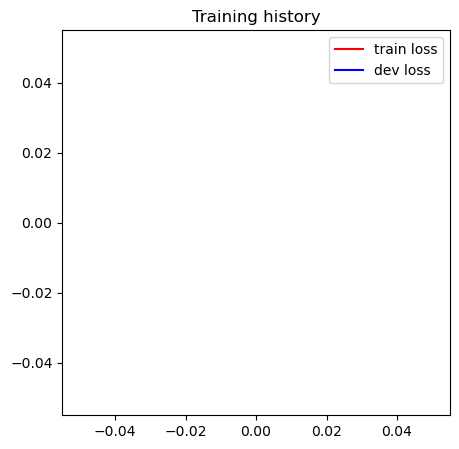

In [26]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()